# Double Inverted Pendulum


This example consists of a double-link pendulum with equal point masses $m$
at the end of connected mass-less links of length $L$. Both links are
actuated with torques $T_1$ and $T_2$ and we assume viscous friction
exists with a coefficient of $c$.

In [1]:
using NeuralNetworkAnalysis
using NeuralNetworkAnalysis: SingleEntryVector, Specification

The following option determines whether the falsification settings should be
used or not. The falsification settings are sufficient to show that the safety
property is violated. Concretely we start from an initial point and use a
smaller time step.

In [2]:
const falsification = true;

## Model

$$
\begin{aligned}
2\ddot \theta_1 + \ddot \theta_2 cos(\theta_2 - \theta_1) - \ddot \theta^2_2 sin(\theta_2 - \theta_1) - 2 \frac{g}{L}sin\theta_1 + \frac{c}{mL^2}\dot\theta_1 &= \frac{1}{mL^2}T_1 \\
\ddot \theta_1 cos(\theta_2 - \theta_1) + \ddot \theta_2 + \ddot \theta^2_1 sin(\theta_2 - \theta_1) - \frac{g}{L}sin\theta_2 + \frac{c}{mL^2}\dot\theta_2 &= \frac{1}{mL^2}T_2
\end{aligned}
$$
where $θ_1$ and $θ_2$ are the angles that links make with the
upward vertical axis. The state is:
$$
\begin{aligned}
[\theta_1, \theta_2, \dot \theta_1, \dot \theta_2]
\end{aligned}
$$
The angular velocity and acceleration of the links are denoted with $θ_1'$,
$θ_2'$, $θ_1''$ and $θ_2''$ and $g$ is the gravitational acceleration.

In [3]:
const m = 0.5
const L = 0.5
const c = 0.0
const g = 1.0
const gL = g/L
const mL = m*L^2;

@taylorize function double_pendulum!(dx, x, p, t)
    x₁, x₂, x₃, x₄, T₁, T₂ = x

    # auxiliary terms
    Δ12 = x₁ - x₂
    ★ = cos(Δ12)
    x3sin12 = x₃^2 * sin(Δ12)
    x4sin12 = x₄^2 * sin(Δ12) / 2
    gLsin1 = gL * sin(x₁)
    gLsin2 = gL * sin(x₂)
    T1_frac = (T₁ - c * x₃) / (2 * mL)
    T2_frac = (T₂ - c * x₄) / mL
    bignum = x3sin12 - ★ * (gLsin1 - x4sin12 + T1_frac) + gLsin2 + T2_frac
    denom = ★^2 / 2 - 1

    dx[1] = x₃
    dx[2] = x₄
    dx[3] = ★ * bignum / (2 * denom) - x4sin12 + gLsin1 + T1_frac
    dx[4] = - bignum / denom
end;

## Specification

In [4]:
function DoublePendulum_model(use_less_robust_controller::Bool)
    net_lr = @modelpath("Double-Pendulum", "controller_double_pendulum_less_robust.nnet")
    net_mr = @modelpath("Double-Pendulum", "controller_double_pendulum_more_robust.nnet")
    controller = read_nnet(use_less_robust_controller ? net_lr : net_mr)

    X₀ = BallInf(fill(1.15, 4), 0.15)
    if falsification
        # choose a single point in the initial states (here: the top-most one)
        if use_less_robust_controller
            X₀ = Singleton(high(X₀))
        else
            X₀ = Singleton(low(X₀))
        end
    end
    U₀ = ZeroSet(2)
    vars_idx = Dict(:state_vars=>1:4, :control_vars=>5:6)
    ivp = @ivp(x' = double_pendulum!(x), dim: 6, x(0) ∈ X₀ × U₀)

    period = use_less_robust_controller ? 0.05 : 0.02  # control period

    prob = ControlledPlant(ivp, controller, vars_idx, period)

    # Safety specification: [x[1], x[2], x[3], x[4]] ∈ safe_states for all t
    if falsification
        if use_less_robust_controller
            k = 5
        else
            k = 7
        end
    else
        k = 20
    end
    T = k * period  # time horizon

    lb = use_less_robust_controller ? -1.0 : -0.5
    ub = use_less_robust_controller ? 1.7 : 1.5
    safe_states = HPolyhedron([HalfSpace(SingleEntryVector(1, 6, 1.0), ub),
                               HalfSpace(SingleEntryVector(1, 6, -1.0), -lb),
                               HalfSpace(SingleEntryVector(2, 6, 1.0), ub),
                               HalfSpace(SingleEntryVector(2, 6, -1.0), -lb),
                               HalfSpace(SingleEntryVector(3, 6, 1.0), ub),
                               HalfSpace(SingleEntryVector(3, 6, -1.0), -lb),
                               HalfSpace(SingleEntryVector(4, 6, 1.0), ub),
                               HalfSpace(SingleEntryVector(4, 6, -1.0), -lb)])
    predicate = X -> isdisjoint(overapproximate(X, Hyperrectangle),
                                safe_states)  # sufficient property for guaranteed violation
    predicate_sol = sol -> any(predicate(R) for F in sol for R in F);

    spec = Specification(T, predicate_sol, safe_states)

    return prob, spec
end;

## Results

In [5]:
import DifferentialEquations

function run(use_less_robust_controller::Bool)
    prob, spec = DoublePendulum_model(use_less_robust_controller)

    alg = TMJets20(abstol=1e-9, orderT=8, orderQ=1)
    alg_nn = Ai2()

    function benchmark(; silent::Bool=false)
        # We solve the controlled system:
        silent || println("flowpipe construction")
        res_sol = @timed solve(prob, T=spec.T, alg_nn=alg_nn, alg=alg)
        sol = res_sol.value
        silent || print_timed(res_sol)

        # Next we check the property for an overapproximated flowpipe:
        solz = overapproximate(sol, Zonotope)
        if spec.predicate(solz)
            silent || println("The property is violated.")
        else
            silent || println("The property may be satisfied.")
        end

        # We also compute some simulations:
        silent || println("simulation")
        trajectories = falsification ? 1 : 10
        res_sim = @timed simulate(prob, T=spec.T, trajectories=trajectories,
                                  include_vertices=!falsification)
        sim = res_sim.value
        silent || print_timed(res_sim)

        return solz, sim
    end;

    benchmark(silent=true)  # warm-up
    if use_less_robust_controller
        println("Running analysis with less robust controller")
    else
        println("Running analysis with more robust controller")
    end
    res = @timed benchmark()  # benchmark
    sol, sim = res.value
    println("total analysis time")
    print_timed(res)

    return sol, sim, prob, spec
end;

# pass flag to choose the controller
# `true`: use a less robust controller
# `false`: use a more robust controller
# the choice also influences settings like the period and the specification
res_true = run(true)
res_false = run(false);

Running analysis with less robust controller
flowpipe construction
  3.674050 seconds (28.73 M allocations: 2.845 GiB, 17.00% gc time)
The property is violated.
simulation
  0.000636 seconds (1.88 k allocations: 156.906 KiB)
total analysis time
  3.735277 seconds (29.07 M allocations: 2.877 GiB, 16.72% gc time)
Running analysis with more robust controller
flowpipe construction
 10.451979 seconds (78.55 M allocations: 7.852 GiB, 15.08% gc time)
The property is violated.
simulation
  0.000828 seconds (2.98 k allocations: 248.516 KiB)
total analysis time
 10.516378 seconds (79.10 M allocations: 7.904 GiB, 14.99% gc time)


Finally we plot the results:

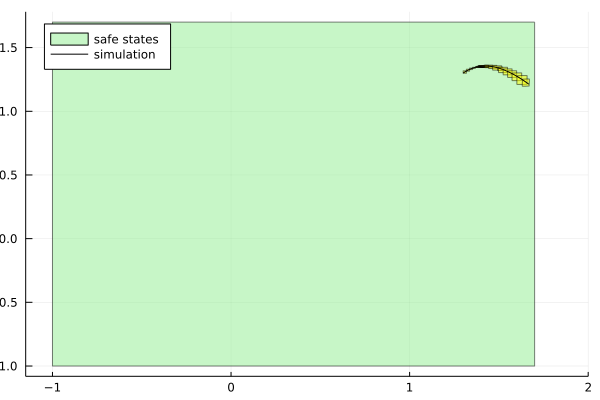

In [6]:
using Plots
import DisplayAs

function plot_helper(fig, vars, sol, sim, prob, spec)
    safe_states = spec.ext
    if vars[1] == 0
        safe_states_projected = project(safe_states, [vars[2]])
        time = Interval(0, T)
        safe_states_projected = cartesian_product(time, safe_states_projected)
    else
        safe_states_projected = project(safe_states, vars)
    end
    plot!(fig, safe_states_projected, color=:lightgreen, lab="safe states")
    if !falsification && 0 ∉ vars
        plot!(fig, project(initial_state(prob), vars), lab="X₀")
    end
    plot!(fig, sol, vars=vars, color=:yellow, lab="")
    lab_sim = falsification ? "simulation" : ""
    plot_simulation!(fig, sim; vars=vars, color=:black, lab=lab_sim)
    fig = DisplayAs.Text(DisplayAs.PNG(fig))
end

vars=(1, 2)
fig = plot(xlab="θ₁", ylab="θ₂")
sol, sim, prob, spec = res_true
if falsification
    plot!(leg=:topleft)
end
xlims!(-0.5, 2.0)
fig = plot_helper(fig, vars, sol, sim, prob, spec)
# savefig("Double-Pendulum-less-robust-x$(vars[1])-x$(vars[2]).png")
fig

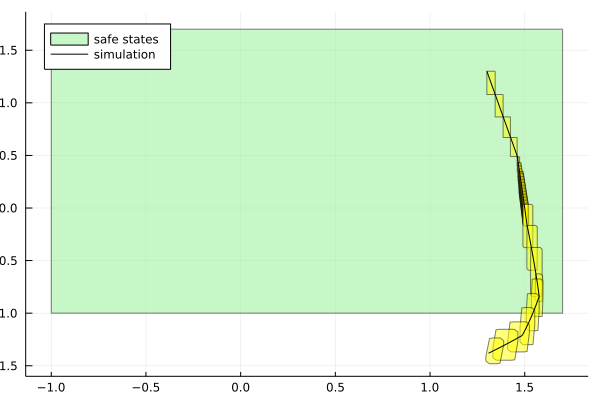

In [7]:
vars=(3, 4)
fig = plot(xlab="θ₁'", ylab="θ₂'")
sol, sim, prob, spec = res_true
if falsification
    plot!(leg=:topleft)
end
xlims!(-0.7, 1.7)
ylims!(-1.6, 1.5)
fig = plot_helper(fig, vars, sol, sim, prob, spec)
# savefig("Double-Pendulum-less-robust-x$(vars[1])-x$(vars[2]).png")
fig

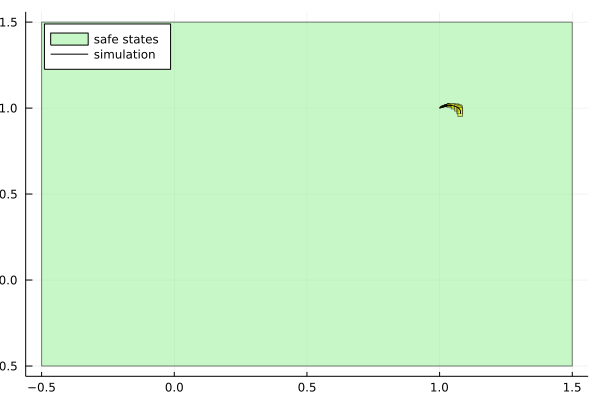

In [8]:
vars=(1, 2)
fig = plot(xlab="θ₁", ylab="θ₂")
sol, sim, prob, spec = res_false
if falsification
    plot!(leg=:topleft)
end
fig = plot_helper(fig, vars, sol, sim, prob, spec)
# savefig("Double-Pendulum-more-robust-x$(vars[1])-x$(vars[2]).png")
fig

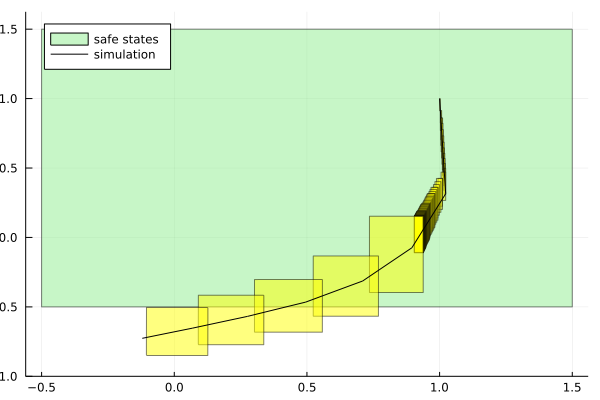

In [9]:
vars=(3, 4)
fig = plot(xlab="θ₁'", ylab="θ₂'")
sol, sim, prob, spec = res_false
if falsification
    plot!(leg=:topleft)
    ylims!(-1.0, 1.5)
else
    xlims!(-1.8, 1.5)
    ylims!(-1.6, 1.5)
end
fig = plot_helper(fig, vars, sol, sim, prob, spec)
# savefig("Double-Pendulum-more-robust-x$(vars[1])-x$(vars[2]).png")
fig